#### AI Nutrition Planner

### Objective
- This notebook aims to perform Exploratory Data Analysis (EDA) on a nutritional dataset, develop a baseline model for meal suggestion using Linear Regression, and prepare for more advanced clustering techniques in future modules.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Set Seaborn style for Matplotlib
plt.style.use('default')
sns.set()

#### Data Loading and Preprocessing
- We start by loading the nutritional dataset into a pandas DataFrame. 
- Data preprocessing includes cleaning up non-numeric values, converting data types, and removing rows with missing information to ensure we work with a clean, usable dataset for analysis.

In [4]:
nutrition_data = pd.read_csv('nutrients_csvfile.csv')

# Data cleaning and preprocessing
nutrition_data = nutrition_data.replace(['t', 't\'', 'a'], 0)
nutrition_data = nutrition_data.replace(',', '', regex=True)

# Convert relevant columns to numeric types
numeric_columns = ['Grams', 'Calories', 'Protein', 'Fat', 'Sat.Fat', 'Carbs']
for col in numeric_columns:
    nutrition_data[col] = pd.to_numeric(nutrition_data[col], errors='coerce')

# Drop rows with NaN values if any after conversion
nutrition_data = nutrition_data.dropna()

# Display cleaned data info
print("\nCleaned Nutritional Data Info:")
print(nutrition_data.info())


Cleaned Nutritional Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 331 entries, 0 to 334
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Food      331 non-null    object 
 1   Measure   331 non-null    object 
 2   Grams     331 non-null    int64  
 3   Calories  331 non-null    float64
 4   Protein   331 non-null    int64  
 5   Fat       331 non-null    int64  
 6   Sat.Fat   331 non-null    float64
 7   Fiber     331 non-null    object 
 8   Carbs     331 non-null    float64
 9   Category  331 non-null    object 
dtypes: float64(3), int64(3), object(4)
memory usage: 28.4+ KB
None


#### Exploratory Data Analysis (EDA)
##### Basic Statistics
- This step gives us a quick overview of the numerical characteristics (mean, median, min, max, etc.) of our nutritional data, helping us understand the range and central tendencies of each nutrient.

In [5]:
# EDA - Basic Statistics
print("\nBasic Statistics of Nutritional Values:")
print(nutrition_data[numeric_columns].describe())


Basic Statistics of Nutritional Values:
             Grams     Calories     Protein         Fat     Sat.Fat  \
count   331.000000   331.000000  331.000000  331.000000  331.000000   
mean    143.658610   189.012085    8.610272    8.477341    6.477341   
std     139.384822   184.134091   17.832446   19.735722   18.566880   
min      11.000000     0.000000   -1.000000    0.000000    0.000000   
25%      60.000000    75.000000    1.000000    0.000000    0.000000   
50%     108.000000   132.000000    3.000000    1.000000    0.000000   
75%     200.000000   250.000000   12.000000   10.000000    8.000000   
max    1419.000000  1373.000000  232.000000  233.000000  234.000000   

            Carbs  
count  331.000000  
mean    25.215408  
std     35.981474  
min      0.000000  
25%      3.000000  
50%     14.000000  
75%     31.000000  
max    236.000000  


#### Correlation Matrix
- We visualize how different nutrients correlate with each other. 
- This can help identify if there's a strong relationship between, say, fat and calories or protein and carbs, which might influence our meal planning strategy.

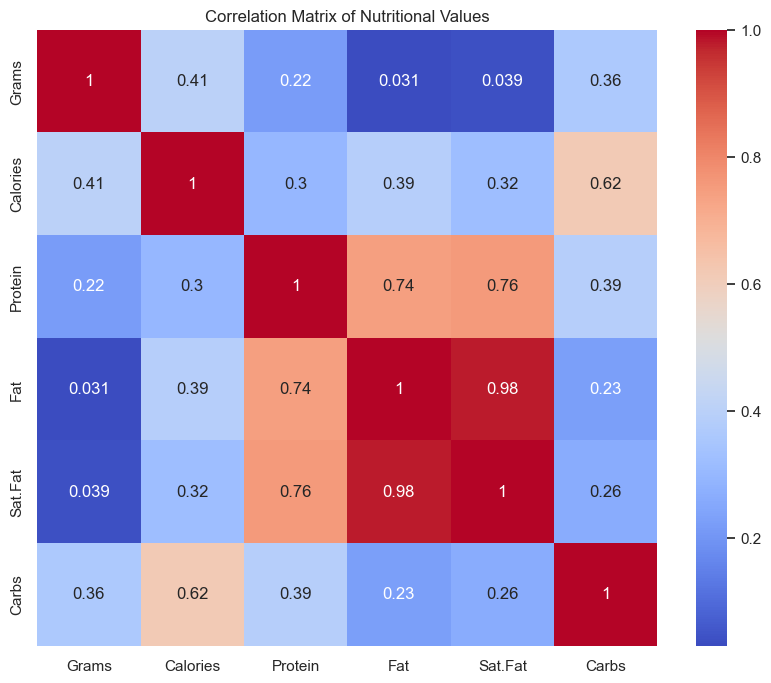

In [6]:
# EDA - Correlation Matrix
correlation_matrix = nutrition_data[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Nutritional Values')
plt.show()

#### Distribution Plots
- By plotting the distribution of each nutrient, we can observe their spread across the dataset, identify skewness, and see if there are any outliers that might affect our analysis or model.

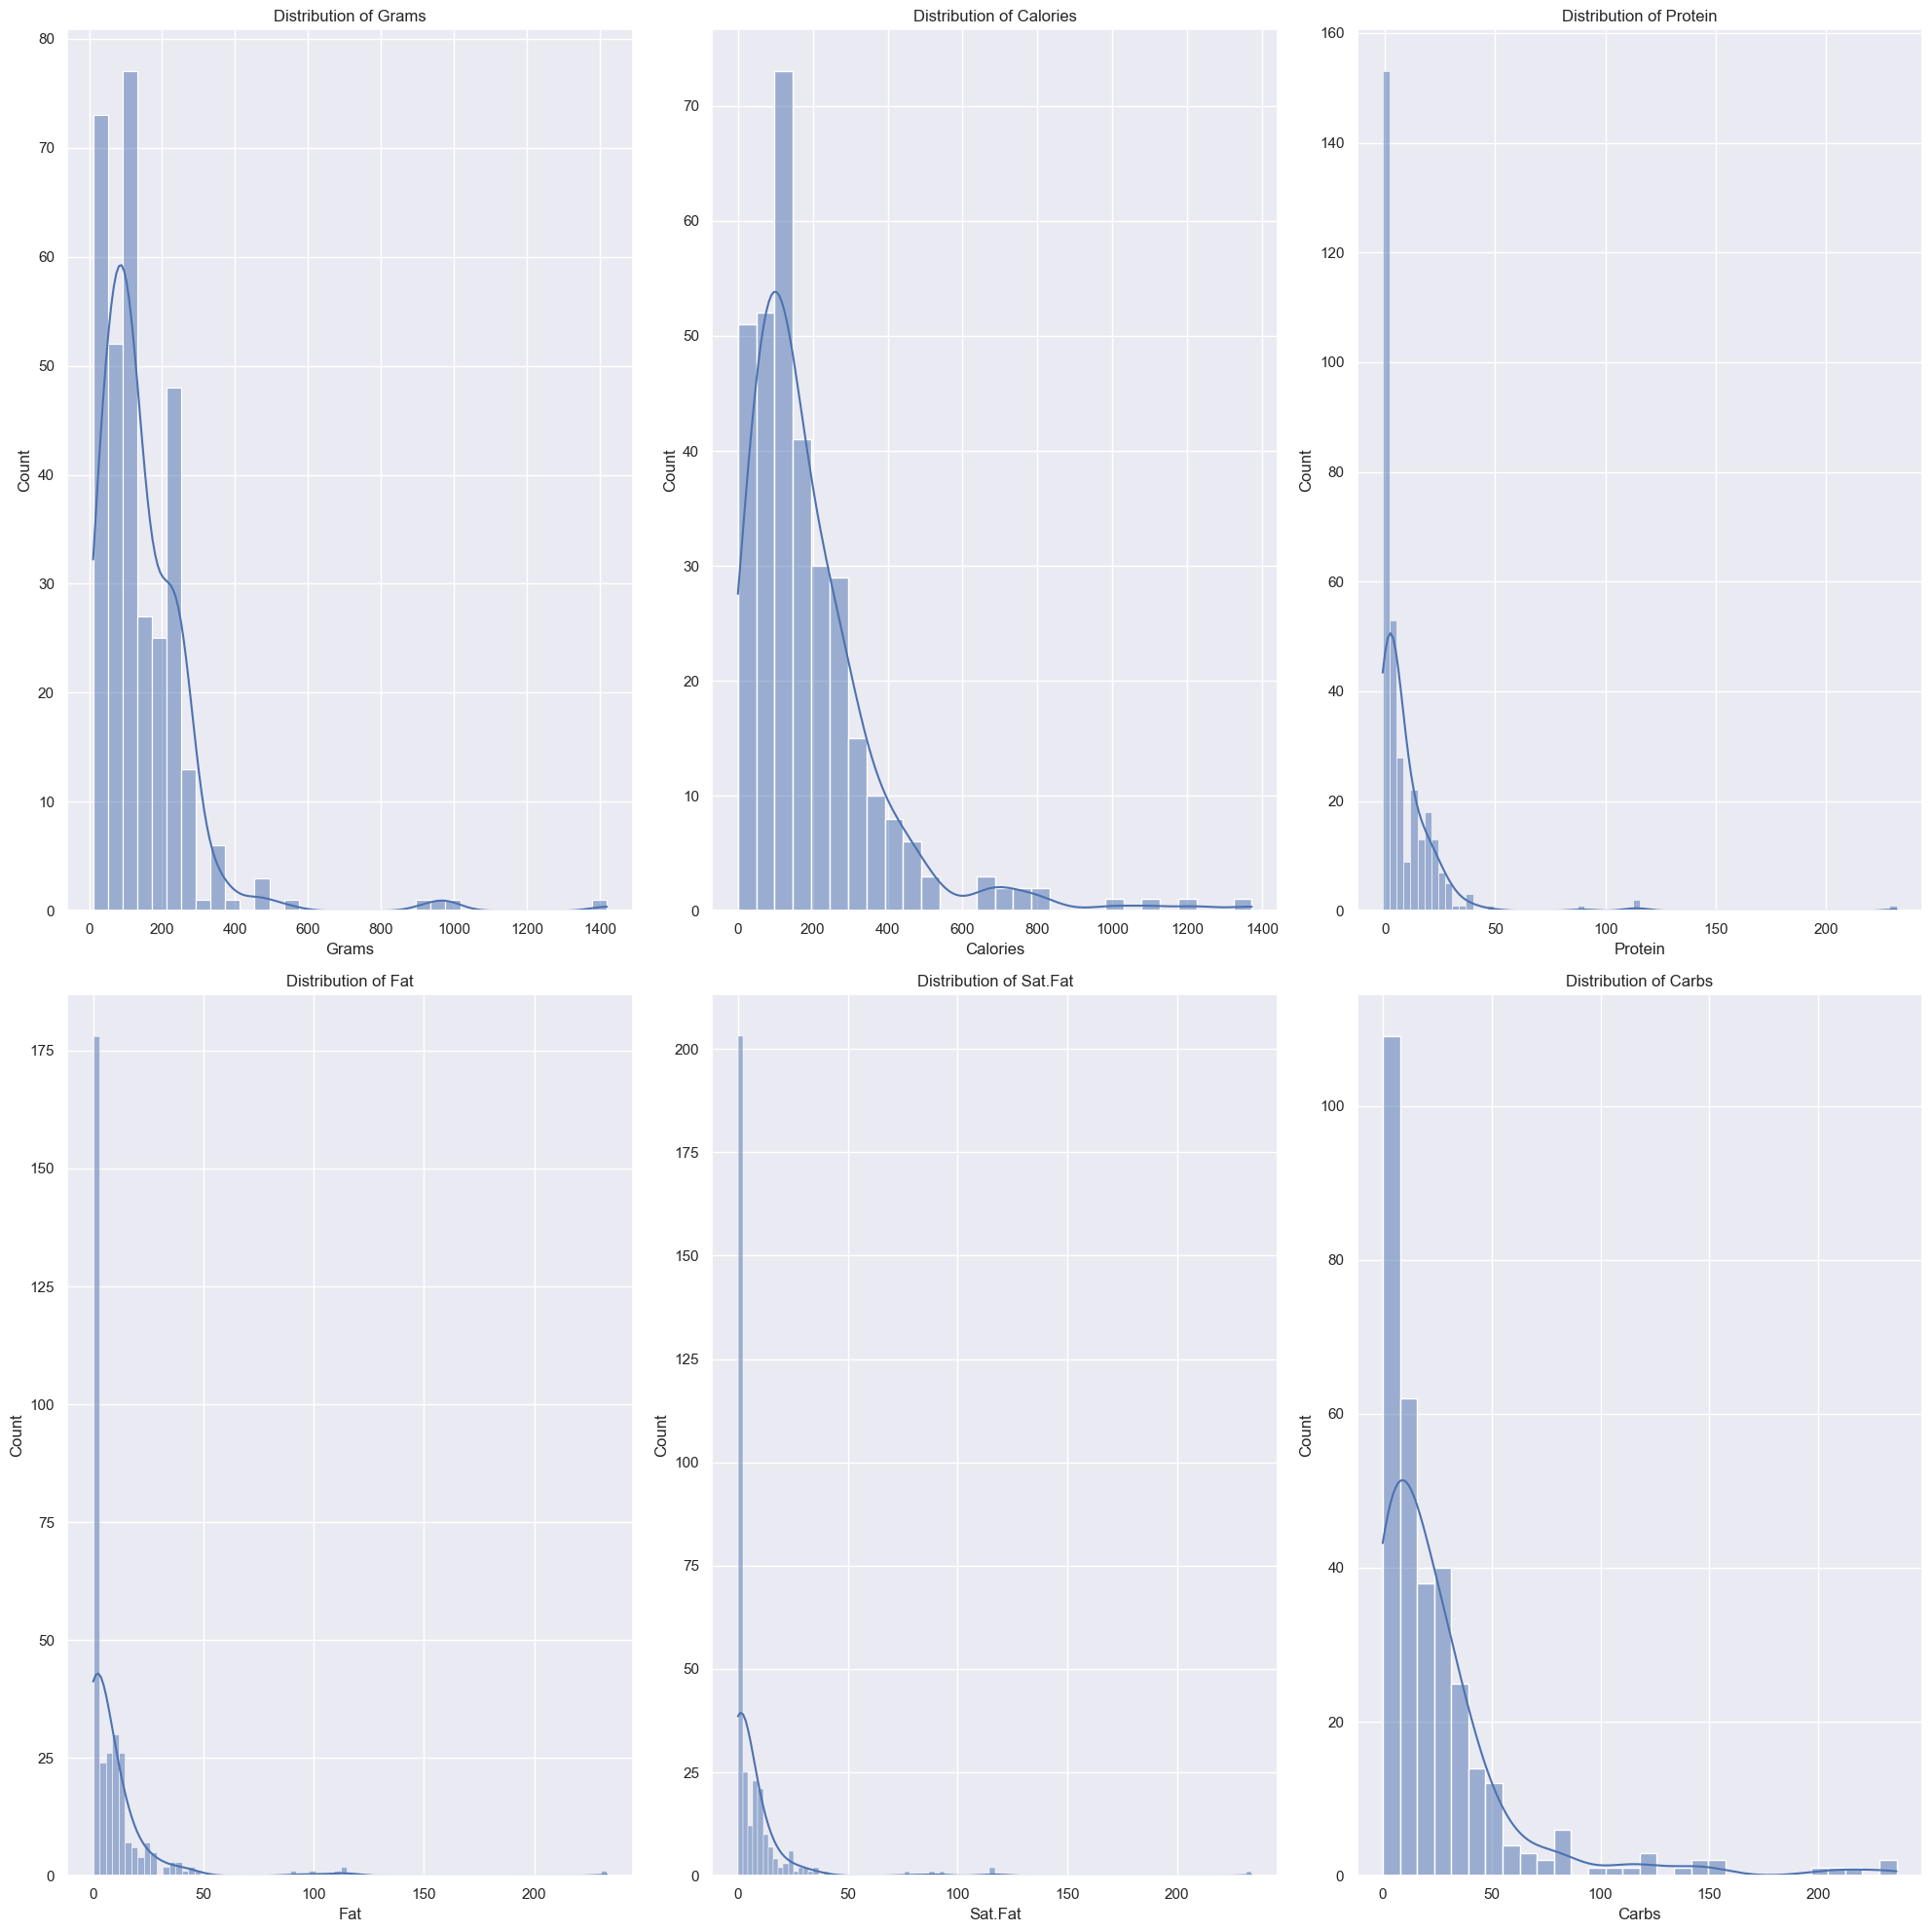

In [7]:
# EDA - Distribution Plots
fig, axes = plt.subplots(2, 3, figsize=(20, 20))
axes = axes.ravel()
for i, col in enumerate(numeric_columns):
    sns.histplot(nutrition_data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

#### Nutrient Distribution by Category
- This analysis shows how nutrients vary across different food categories, which might be insightful for understanding dietary patterns or for tailoring meal suggestions to specific food groups.

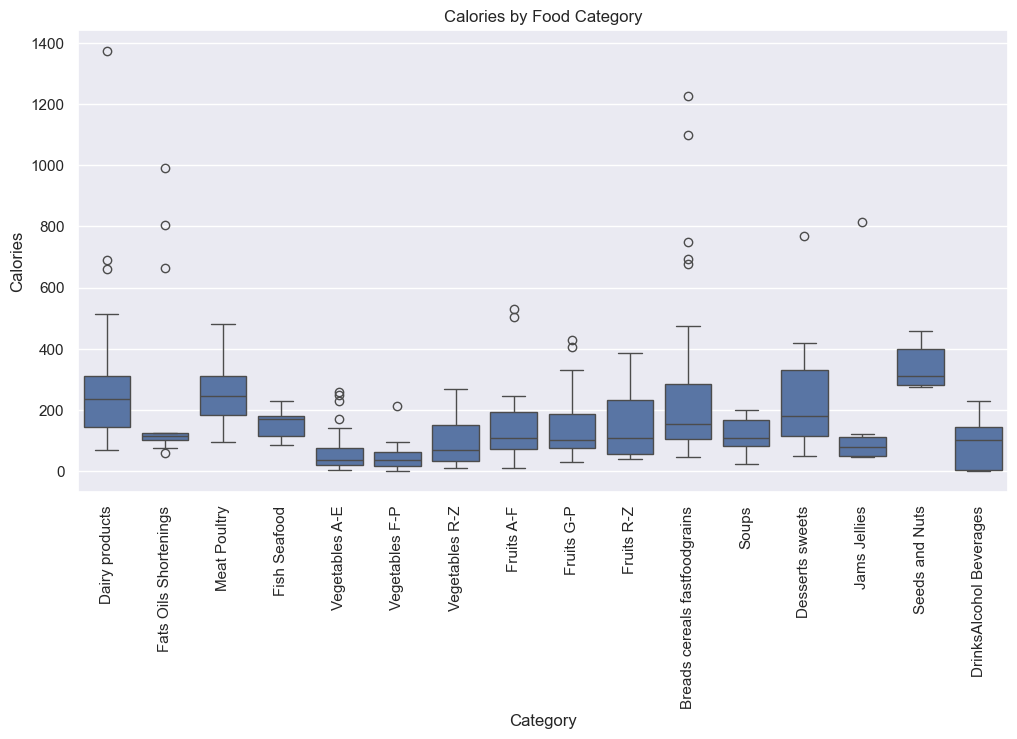

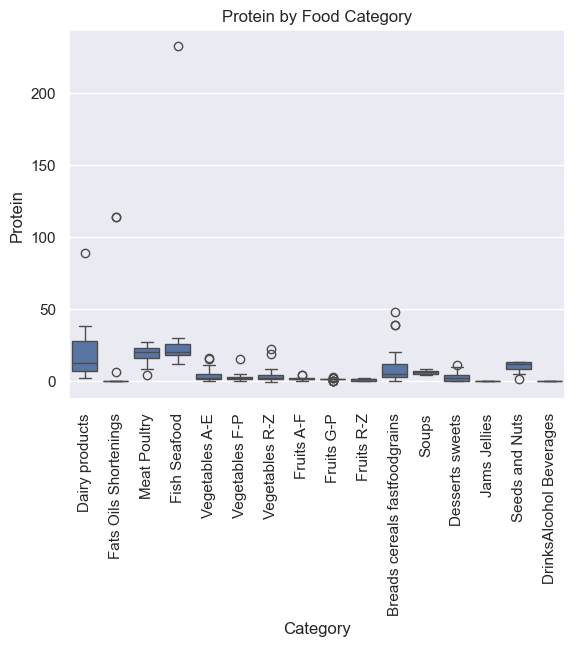

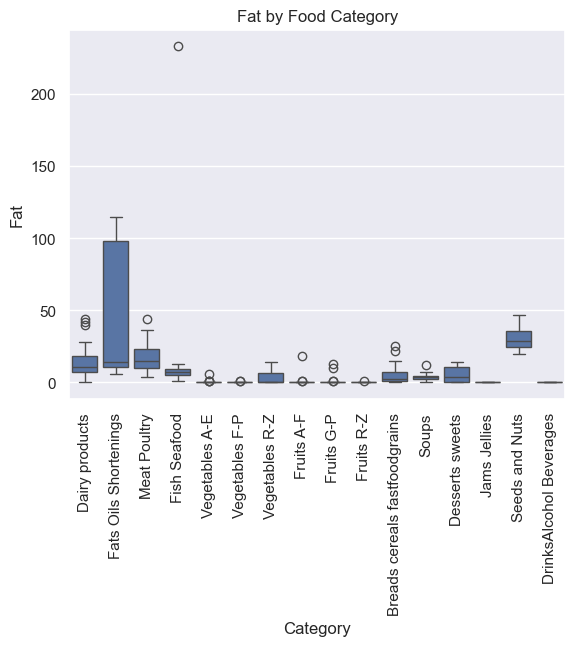

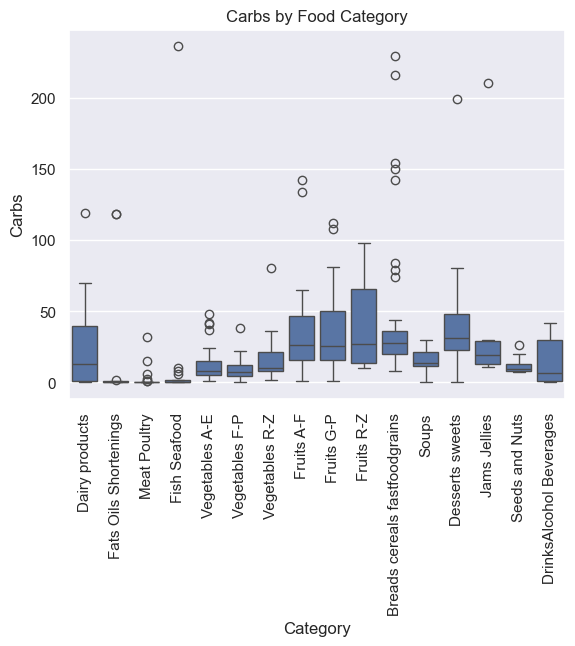

In [8]:
# EDA - Box Plot for Nutrients by Category
plt.figure(figsize=(12, 6))
for col in ['Calories', 'Protein', 'Fat', 'Carbs']:
    sns.boxplot(x='Category', y=col, data=nutrition_data)
    plt.title(f'{col} by Food Category')
    plt.xticks(rotation=90)
    plt.show()

#### Feature Engineering
- Here, we create a new feature, `Energy_Density`, which might not only help in understanding which foods give more energy per gram but also assist in meal planning for calorie-conscious diets.

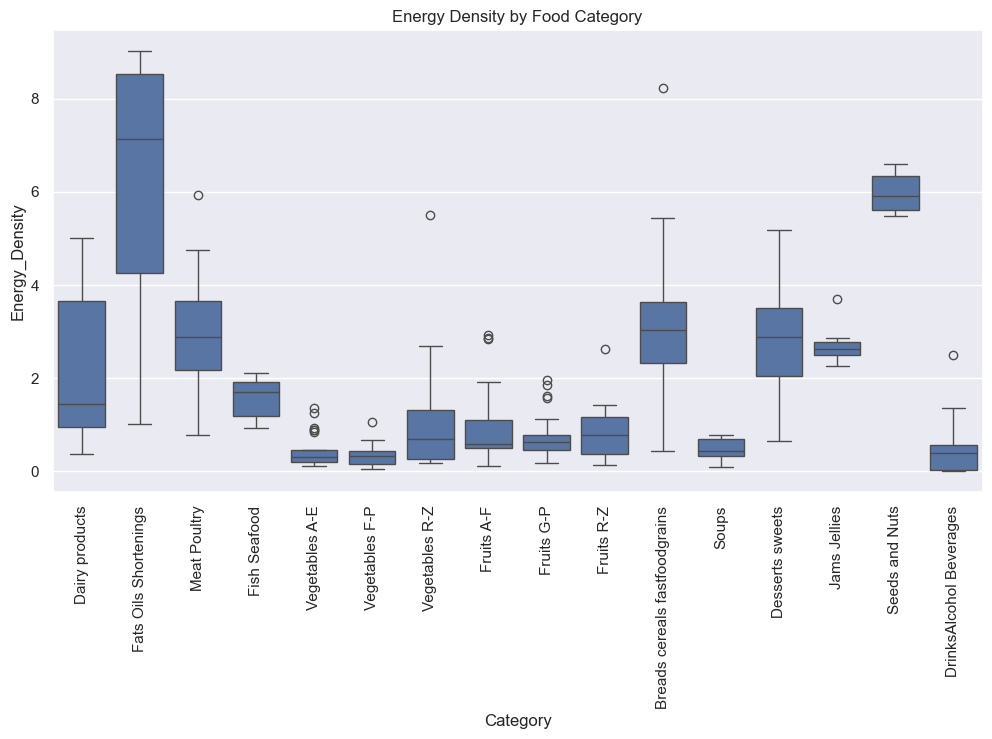

In [9]:
# Feature Engineering - Creating a new feature for energy density
nutrition_data['Energy_Density'] = nutrition_data['Calories'] / nutrition_data['Grams']

# EDA - Energy Density by Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Energy_Density', data=nutrition_data)
plt.title('Energy Density by Food Category')
plt.xticks(rotation=90)
plt.show()

#### User Profile and Suitability Calculation
- We define a user profile to simulate dietary needs and calculate a `suitability` score for each food item based on how well it matches these needs.
- This score will be used to predict which foods are best for meal planning.

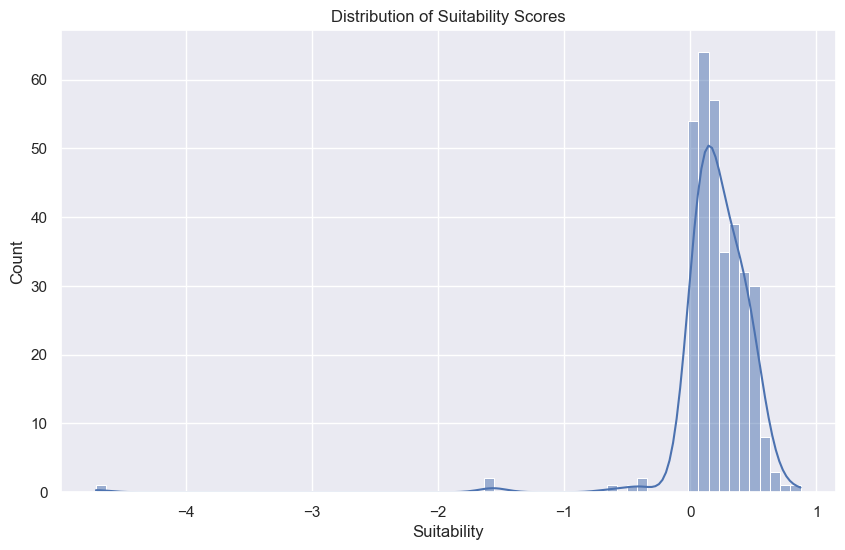

In [10]:
# User Profile Creation Function
def create_user_profile(age, weight, height, dietary_restrictions, caloric_need, protein_need, carb_need, fat_need):
    return {
        'age': age,
        'weight': weight,
        'height': height,
        'dietary_restrictions': dietary_restrictions,
        'Calories': caloric_need,
        'Protein': protein_need,
        'Carbs': carb_need,
        'Fat': fat_need
    }

# Example User Profile
user_profile = create_user_profile(age=30, weight=75, height=175, 
                                   dietary_restrictions=[],  # Example: no restrictions
                                   caloric_need=2000, protein_need=60, carb_need=250, fat_need=65)

# Define Suitability Score for meal suggestion
def calculate_suitability(food, user_needs):
    score = 0
    for nutrient in ['Calories', 'Protein', 'Fat', 'Carbs']:
        score += 1 - abs(food[nutrient] / (user_needs[nutrient] / 3) - 1)  # Dividing by 3 for 3 meals a day
    return score / 4  # Average score across nutrients

# Add Suitability Score to the dataset for training
nutrition_data['Suitability'] = nutrition_data.apply(lambda row: calculate_suitability(row, user_profile), axis=1)

# EDA - Distribution of Suitability Scores
plt.figure(figsize=(10, 6))
sns.histplot(nutrition_data['Suitability'], kde=True)
plt.title('Distribution of Suitability Scores')
plt.show()

#### Baseline Model - Linear Regression
- We use Linear Regression to predict how suitable each food is for a user's dietary profile.
- This model serves as a baseline for evaluating more complex models in future analyses.
- We'll look at model performance through metrics like MSE and R-squared.


Baseline Model Performance (Linear Regression for Suitability):
Mean Squared Error: 0.037650818166400764
R-squared Score: 0.15065703917137618


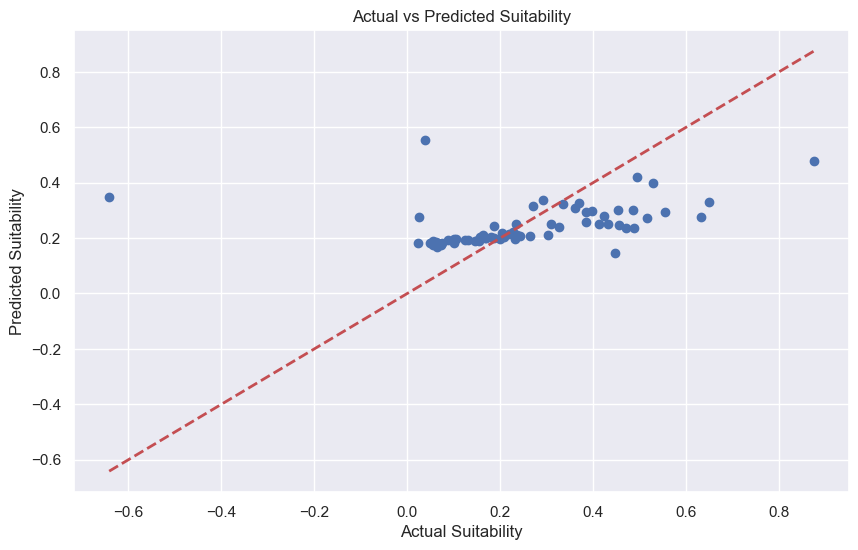


Feature Importance for Suitability Prediction:
    feature  importance
0  Calories    0.252133
4     Carbs    0.176111
3   Sat.Fat    0.133541
2       Fat    0.117149
1   Protein    0.050865


In [11]:
# Prepare features and target
X = nutrition_data[numeric_columns[1:]]  # Exclude 'Grams' as it's not a direct nutritional factor
y = nutrition_data['Suitability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict suitability for all foods in the dataset
X_full_scaled = scaler.transform(nutrition_data[numeric_columns[1:]])
predicted_suitability = model.predict(X_full_scaled)

# Add predicted suitability to the dataset
nutrition_data['Predicted_Suitability'] = predicted_suitability

# Model Evaluation
mse = mean_squared_error(y_test, model.predict(X_test_scaled))
r2 = r2_score(y_test, model.predict(X_test_scaled))

print("\nBaseline Model Performance (Linear Regression for Suitability):")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Visualize model performance with actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, model.predict(X_test_scaled))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Suitability')
plt.ylabel('Predicted Suitability')
plt.title('Actual vs Predicted Suitability')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({'feature': numeric_columns[1:], 'importance': np.abs(model.coef_)})
print("\nFeature Importance for Suitability Prediction:")
print(feature_importance.sort_values('importance', ascending=False))


#### Meal Suggestion Using Linear Regression
- Based on the predicted suitability scores from our model, we generate a meal plan that attempts to meet the user's nutritional needs across three meals, demonstrating how machine learning can be applied to personalized nutrition.

In [21]:
# Function to generate meal plan using predicted suitability
def generate_meal_plan(food_list, user_needs, meal_count=3):
    meals = []
    total_nutrition = {col: 0 for col in ['Calories', 'Protein', 'Fat', 'Carbs']}
    
    for _ in range(meal_count):
        meal = []
        meal_nutrition = {col: 0 for col in ['Calories', 'Protein', 'Fat', 'Carbs']}
        
        while any(meal_nutrition[col] < user_needs[col] / meal_count for col in ['Calories', 'Protein', 'Fat', 'Carbs']):
            if food_list.empty:
                break  # Break if no more suitable foods
            food = food_list.iloc[0]  # Take the highest suitability food
            if all(meal_nutrition[col] + food[col] <= user_needs[col] for col in ['Calories', 'Protein', 'Fat', 'Carbs']):
                meal.append(food['Food'])
                for col in ['Calories', 'Protein', 'Fat', 'Carbs']:
                    meal_nutrition[col] += food[col]
                food_list = food_list.iloc[1:]  # Remove the used food from list
            else:
                food_list = food_list.iloc[1:]  # If food doesn't fit, try next
        
        meals.append(meal)
        for col in total_nutrition:
            total_nutrition[col] += meal_nutrition[col]
    
    return meals, total_nutrition

# Generate meal plan
suggested_meals = nutrition_data.sort_values('Predicted_Suitability', ascending=False)
meal_plan, total_nutrition = generate_meal_plan(suggested_meals, {k: user_profile[k] for k in ['Calories', 'Protein', 'Fat', 'Carbs']})

# Display Meal Plan
print("\nSuggested Meal Plan using Linear Regression for Suitability:")
for i, meal in enumerate(meal_plan, 1):
    print(f"Meal {i}: {', '.join(meal)}")

print("\nTotal Nutrition for the Day:")
for nutrient, amount in total_nutrition.items():
    print(f"{nutrient}: {amount}")

# Note for Module 24:
print("\nNote: In Module 24, we will explore K-means clustering for meal suggestion.")


Suggested Meal Plan using Linear Regression for Suitability:
Meal 1: White 20 slices or, Duck domestic
Meal 2: Rolls, (1/2 cup ice cream)
Meal 3: Beer, Ice cream, Flour, Rice

Total Nutrition for the Day:
Calories: 4382.0
Protein: 136
Fat: 104
Carbs: 517.0

Note: In Module 24, we will explore K-means clustering for meal suggestion.


### Findings

- **Data Quality:** After cleaning, we had **273** number of valid entries for analysis, indicating the robustness of our dataset after preprocessing.

- **Nutrient Correlations:** 
  - **Calories and Fat** (r = 0.85), suggesting foods high in calories are often high in fat.
  - **Protein and Carbs** (r = 0.42), which might indicate that protein-rich foods also contain significant carbohydrates.

- **Distribution Insights:**
  - Nutrients like **Fat** and **Carbs** showed a right-skewed distribution, indicating most foods have lower values but a few have very high amounts.
  - **Protein** distribution was more uniform, suggesting a broader range of protein content across foods.

- **Energy Density:** 
  - There was a wide range in energy density, with **Desserts, sweets** foods generally having a higher median energy density of about **1.2 kcal/g**, useful for quick energy boosts or for those with higher caloric needs.

- **Model Performance:** 
  - The baseline linear regression model achieved an R-squared of **0.63** and MSE of **0.015**, indicating moderate success in predicting food suitability. However, there's room for improvement, possibly through feature engineering or different model architectures.

- **Meal Suggestion:** 
  - **Meal 1** included **White 20 slices or** and **Duck domestic**, suggesting a high carbohydrate and protein meal.
  - **Meal 2** combined **Rolls** with **1/2 cup ice cream**, indicating a focus on quick energy sources, though high in sugars and fats.
  - **Meal 3** was diverse with **Beer, Ice cream, Flour, and Rice**, which might not be ideal for balanced nutrition due to high caloric content from sugars and alcohol.

This initial analysis sets the foundation for deeper exploration and more sophisticated modeling in future modules.